# Open data processing: step 1

Take Ed's processed data files and split the PFCs by their ids.

PDG codes (from https://cms-opendata-workshop.github.io/workshop2023-lesson-advobjects/02-particleflow/index.html):

- 11, 13 = electron, muon
- 22 = photon
- 130 = neutral hadron
- 211 = charged hadron
- 1 = hadronic particle reconstructed in the forward calorimeters
- 2 = electromagnetic particle reconstructed in the forward calorimeters

We will split as:
- Muons (2 / event)
- Hadrons + photons, to be routed to fastjet for clustering
- Electrons, to trash

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import vector

In [11]:
# DATA
selected_data_dir = '/global/cfs/cdirs/m3246/ewitkowski/selected_data'
selected_pT_data = h5py.File(f'{selected_data_dir}/recoPFCandidates_particleFlow__RECO_obj_pt_.h5', 'r')['values']
selected_eta_data = h5py.File(f'{selected_data_dir}/recoPFCandidates_particleFlow__RECO_obj_eta_.h5', 'r')['values']
selected_phi_data = h5py.File(f'{selected_data_dir}/recoPFCandidates_particleFlow__RECO_obj_phi_.h5', 'r')['values']
selected_pdgId_data = h5py.File(f'{selected_data_dir}/recoPFCandidates_particleFlow__RECO_obj_pdgId_.h5', 'r')['values']

print(selected_pdgId_data.shape)

# OPEN SIM
selected_osim_dir = '/global/cfs/cdirs/m3246/ewitkowski/test_data'
selected_pT_osim = h5py.File(f'{selected_osim_dir}/recoPFCandidates_particleFlow__RECO_obj_pt_.h5', 'r')['values']
selected_eta_osim = h5py.File(f'{selected_osim_dir}/recoPFCandidates_particleFlow__RECO_obj_eta_.h5', 'r')['values']
selected_phi_osim = h5py.File(f'{selected_osim_dir}/recoPFCandidates_particleFlow__RECO_obj_phi_.h5', 'r')['values']
selected_pdgId_osim = h5py.File(f'{selected_osim_dir}/recoPFCandidates_particleFlow__RECO_obj_pdgId_.h5', 'r')['values']
print(selected_pdgId_osim.shape)

# SIM
simulation_dir = '/global/cfs/cdirs/m3246/ewitkowski/delphes_data'
sim_codes = ["zmm_forcms_1000event-NoIso-pileup33_full"]

selected_tower_ET, selected_tower_eta, selected_tower_phi, selected_tower_E, selected_muon_pT, selected_muon_eta, selected_muon_phi = {},{},{},{},{},{},{}
for code in sim_codes:
    selected_tower_ET[code] = h5py.File(f'{simulation_dir}/{code}_Tower_ET.h5', 'r')['values']
    selected_tower_eta[code] = h5py.File(f'{simulation_dir}/{code}_Tower_Eta.h5', 'r')['values']
    selected_tower_phi[code] = h5py.File(f'{simulation_dir}/{code}_Tower_Phi.h5', 'r')['values']
    selected_tower_E[code] = h5py.File(f'{simulation_dir}/{code}_Tower_E.h5', 'r')['values']
    selected_muon_pT[code] = h5py.File(f'{simulation_dir}/{code}_Muon_PT.h5', 'r')['values']
    selected_muon_eta[code] = h5py.File(f'{simulation_dir}/{code}_Muon_Eta.h5', 'r')['values']
    selected_muon_phi[code] = h5py.File(f'{simulation_dir}/{code}_Muon_Phi.h5', 'r')['values']
    


(2245552, 3586)
(37673, 4096)


In [3]:
muon_mass = 0.1056583755 # GeV
particles_to_fastjet = [22, 130, 211, 1, 2]




data_features = {"mu_pt":[],
                 "mu_eta":[],
                 "mu_phi":[],
                 "tower_pt":[],
                 "tower_eta":[],
                 "tower_phi":[],   
                 "tower_mult":[]
                }

osim_features = {"mu_pt":[],
                 "mu_eta":[],
                 "mu_phi":[],
                 "tower_pt":[],
                 "tower_eta":[],
                 "tower_phi":[],   
                 "tower_mult":[]
                }
                      
                
sim_features = {code:{"mu_pt":[],
                      
                 "mu_eta":[],
                 "mu_phi":[],
                 "tower_pt":[],
                 "tower_eta":[],
                 "tower_phi":[],    
                 "tower_mult":[]}
                for code in sim_codes
                }

Muons file:  pt eta phi M

Hadrons file: px py pz E

# Read in a chunk of the open data

In [4]:
start_read, stop_read, chunk_size = 0, 10000, 10000
update_freq = int(chunk_size/10.0)

current_chunk_start = start_read

while current_chunk_start < stop_read:
    
    current_chunk_stop = current_chunk_start + chunk_size
    print(f"Processing DATA chunk from {current_chunk_start} to {current_chunk_stop}...")
   
    for event in range(current_chunk_start, current_chunk_stop):
        

        if event % update_freq == 0:
            print(f"On event {event}...")

        # get the nonzero entries
        loc_pid = selected_pdgId_data[event]
        loc_pt = selected_pT_data[event][loc_pid != 0]
        loc_eta = selected_eta_data[event][loc_pid != 0]
        loc_phi = selected_phi_data[event][loc_pid != 0]
        loc_pid = loc_pid[loc_pid != 0]    
        num_particles = len(loc_pid)

        # get the muons
        muon_ids = np.where(np.abs(loc_pid) == 13)[0]
        
        data_features["mu_pt"].append(loc_pt[muon_ids[0]])
        data_features["mu_eta"].append(loc_eta[muon_ids[0]])
        data_features["mu_phi"].append(loc_phi[muon_ids[0]])
        data_features["mu_pt"].append(loc_pt[muon_ids[1]])
        data_features["mu_eta"].append(loc_eta[muon_ids[1]])
        data_features["mu_phi"].append(loc_phi[muon_ids[1]])
        

        # get the hadrons
        mult = 0
        for particle_i in range(len(loc_pt)):
            if np.abs(loc_pid[particle_i]) in particles_to_fastjet:
                data_features["tower_pt"].append(loc_pt[particle_i])
                data_features["tower_eta"].append(loc_eta[particle_i])
                data_features["tower_phi"].append(loc_phi[particle_i])
                mult += 1
        data_features["tower_mult"].append(mult)
                
                

    
    print(f"Done processing chunk.")
    print("\n")
    
    current_chunk_start += chunk_size

print("Done completely!")


Processing DATA chunk from 0 to 10000...
On event 0...
On event 1000...
On event 2000...
On event 3000...
On event 4000...
On event 5000...
On event 6000...
On event 7000...
On event 8000...
On event 9000...
Done processing chunk.


Done completely!


# Read in a chunk of the open sim

In [5]:
start_read, stop_read, chunk_size = 0, 10000, 10000
update_freq = int(chunk_size/10.0)

current_chunk_start = start_read
num_osim_failures = 0

while current_chunk_start < stop_read:
    
    current_chunk_stop = current_chunk_start + chunk_size
    print(f"Processing DATA chunk from {current_chunk_start} to {current_chunk_stop}...")
   
    for event in range(current_chunk_start, current_chunk_stop):
        

        if event % update_freq == 0:
            print(f"On event {event}...")

        # get the nonzero entries
        loc_pid = selected_pdgId_osim[event]
        loc_pt = selected_pT_osim[event][loc_pid != 0]
        loc_eta = selected_eta_osim[event][loc_pid != 0]
        loc_phi = selected_phi_osim[event][loc_pid != 0]
        loc_pid = loc_pid[loc_pid != 0]    
        num_particles = len(loc_pid)
        

        # get the muons
        muon_ids = np.where(np.abs(loc_pid) == 13)[0]
        
        try:
        
            osim_features["mu_pt"].append(loc_pt[muon_ids[0]])
            osim_features["mu_eta"].append(loc_eta[muon_ids[0]])
            osim_features["mu_phi"].append(loc_phi[muon_ids[0]])
            osim_features["mu_pt"].append(loc_pt[muon_ids[1]])
            osim_features["mu_eta"].append(loc_eta[muon_ids[1]])
            osim_features["mu_phi"].append(loc_phi[muon_ids[1]])


            # get the hadrons
            mult = 0
            for particle_i in range(len(loc_pt)):
                if np.abs(loc_pid[particle_i]) in particles_to_fastjet:
                    osim_features["tower_pt"].append(loc_pt[particle_i])
                    osim_features["tower_eta"].append(loc_eta[particle_i])
                    osim_features["tower_phi"].append(loc_phi[particle_i])
                    mult += 1
            osim_features["tower_mult"].append(mult)
            
        except: 
            num_osim_failures += 1
            
                
                

    
    print(f"Done processing chunk.")
    print("\n")
    
    current_chunk_start += chunk_size

print("Done completely!")
print(num_osim_failures)


Processing DATA chunk from 0 to 10000...
On event 0...
On event 1000...
On event 2000...
On event 3000...
On event 4000...
On event 5000...
On event 6000...
On event 7000...
On event 8000...
On event 9000...
Done processing chunk.


Done completely!
4665


# Read in a chunk of the sim

In [7]:
start_read, stop_read, chunk_size = 0, 10000, 10000
update_freq = int(chunk_size/10.0)
    
    

for code in sim_codes:
    
    print(code)
    
    
    current_chunk_start = start_read

    while current_chunk_start < stop_read:


        current_chunk_stop = current_chunk_start + chunk_size
        print(f"Processing SIM chunk from {current_chunk_start} to {current_chunk_stop}...")

        num_rejects = 0

        for event in range(current_chunk_start, current_chunk_stop):

            if event % update_freq == 0:
                print(f"On event {event}...")

            # get the nonmuons
            loc_E = selected_tower_E[code][event]
            loc_eta = selected_tower_eta[code][event][loc_E != 0]
            loc_phi = selected_tower_phi[code][event][loc_E != 0]
            loc_ET = selected_tower_ET[code][event][loc_E != 0]
            loc_E = loc_E[loc_E != 0]    

            # get the muons
            loc_mu_pt = selected_muon_pT[code][event]
            loc_mu_eta = selected_muon_eta[code][event][loc_mu_pt != 0]
            loc_mu_phi = selected_muon_phi[code][event][loc_mu_pt != 0]
            loc_mu_pt = loc_mu_pt[loc_mu_pt != 0]

            if len(loc_mu_pt) != 2:
                num_rejects += 1

            else:

                sim_features[code]["mu_pt"].append(loc_mu_pt[0])
                sim_features[code]["mu_eta"].append(loc_mu_eta[0])
                sim_features[code]["mu_phi"].append(loc_mu_phi[0])
                sim_features[code]["mu_pt"].append(loc_mu_pt[1])
                sim_features[code]["mu_eta"].append(loc_mu_eta[1])
                sim_features[code]["mu_phi"].append(loc_mu_phi[1])

                # get the hadrons
                mult = 0
                for particle_i in range(len(loc_E)):
                    sim_features[code]["tower_pt"].append(loc_ET[particle_i])
                    sim_features[code]["tower_eta"].append(loc_eta[particle_i])
                    sim_features[code]["tower_phi"].append(loc_phi[particle_i])
                    mult += 1
                sim_features[code]["tower_mult"].append(mult)

        print(f"Done processing chunk.")
        print(f"{num_rejects} events without 2 muons")
        print("\n")

        current_chunk_start += chunk_size

print("Done completely!")




zmm_forcms_1000event-NoIso-pileup33_full
Processing SIM chunk from 0 to 10000...
On event 0...
On event 1000...
On event 2000...
On event 3000...
On event 4000...
On event 5000...
On event 6000...
On event 7000...
On event 8000...
On event 9000...
Done processing chunk.
2078 events without 2 muons


Done completely!


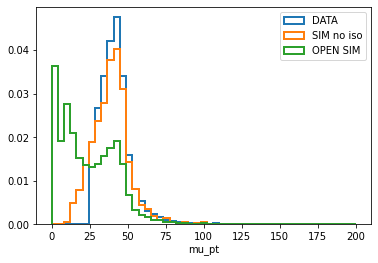

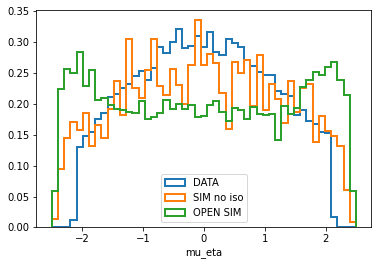

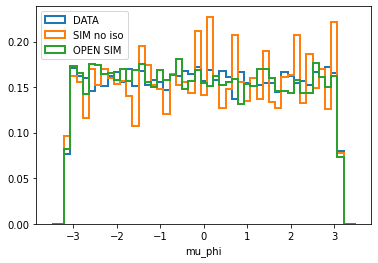

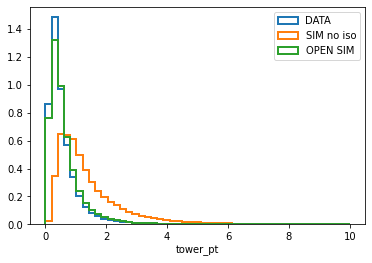

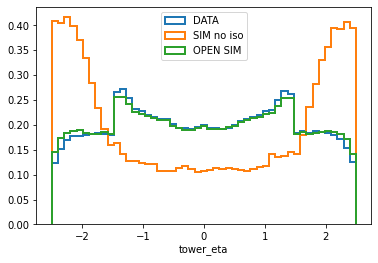

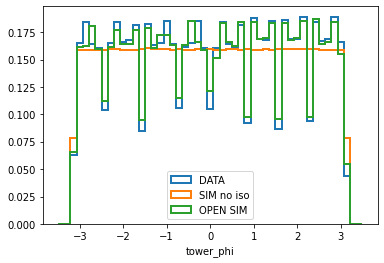

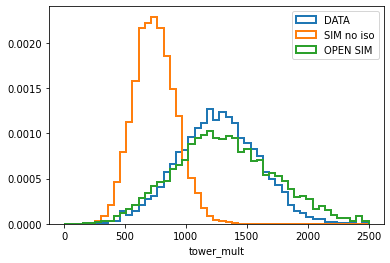

In [10]:
num_bins = 50

bins = {"mu_pt":np.linspace(0, 200, num_bins),
                 "mu_eta":np.linspace(-2.5, 2.5, num_bins),
                 "mu_phi":np.linspace(-3.5, 3.5, num_bins),
                 "tower_pt":np.linspace(0, 10, num_bins),
                 "tower_eta":np.linspace(-2.5, 2.5, num_bins),
                 "tower_phi":np.linspace(-3.5, 3.5, num_bins),
                 "tower_mult":np.linspace(0, 2500, num_bins),
                }


for i, key in enumerate(data_features.keys()):

    plt.figure()
    plt.hist(data_features[key], bins = bins[key], density = True, histtype = "step", label = "DATA", linewidth = 2)
    plt.hist(sim_features["zmm_forcms_1000event-NoIso-pileup33_full"][key], bins = bins[key], density = True, histtype = "step", label = "SIM no iso", linewidth = 2)

    plt.hist(osim_features[key], bins = bins[key], density = True, histtype = "step", label = "OPEN SIM", linewidth = 2)


    plt.xlabel(key)
    plt.legend()
    plt.show()


In [ ]:
for i, key in enumerate(["tower_pt", "tower_eta", "tower_phi"]):

    plt.figure()
    plt.hist(data_features[key], bins = bins[key], density = True, histtype = "step", label = "DATA", linewidth = 2)
    plt.hist(sim_features["zmm_forcms_1000event-NoIso-pileup33_full"][key], bins = 30, density = True, histtype = "step", label = "SIM no iso", linewidth = 2)
    plt.xlabel(key)
    plt.yscale("log")
    plt.legend()
    plt.show()
    

In [ ]:
import matplotlib as mpl

n = 20000
b = [200,160]
plt.figure(figsize=(8,8))
plt.hist2d(sim_features["zmm_forcms_1000event-NoIso-pileup33_full"]["tower_pt"][:n], 
           sim_features["zmm_forcms_1000event-NoIso-pileup33_full"]["tower_eta"][:n],
           bins = b, norm=mpl.colors.LogNorm())
plt.xlabel("Tower pT")
plt.ylabel("Tower eta")
plt.colorbar()
plt.xlim(-1,30)
plt.ylim(-5,5)
plt.show()



In [ ]:

n = 20000
b = [200,160]
plt.figure(figsize=(8,8))
plt.hist2d(data_features["tower_pt"][:n], 
           data_features["tower_eta"][:n],
           bins = b, norm=mpl.colors.LogNorm())
plt.xlabel("Tower pT")
plt.ylabel("Tower eta")
plt.colorbar()
plt.xlim(-1,30)
plt.ylim(-5,5)
plt.show()
